### 📌ACTIVIDAD 2: UN CASO DE REGRESIÓN MÁS REAL

Crea el notebook saa_u03_p01_a2-<tus_iniciales>.ipynb donde entregar esta actividad. En el fichero
centro-comercial.csv tenemos registrada la facturación semanal conseguida en unos 45 centros comerciales de una cadena de supermercados registrada un día concreto de cada semana. Tenemos datos de varios años y queremos tener un modelo de Machine Learning que nos permita predecir las ventas semanales a partir de otros datos que se indiquen

Nota: este ejercicio tiene un obstáculo que debes detectar para poder resolverlo de manera correcta (a mi se me ocurren dos posibles soluciones aplicadas en la fase de preprocesamiento y en el ajuste de parámetros, aunque solamente he probado una y es posible que haya más)

#### COMPARATIVA DE VARIOS REGRESORES

Carga en un DataFrame el archivo centro-comercial.csv y realiza este preprocesamiento básico: análisis exploratorio de datos y selección de características

In [60]:
#Librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [61]:
df = pd.read_csv("centro-comercial.csv")
df.head()

,centro,fecha,ventas_semanales,festivo,temperatura,precio_gasolina,IPC,desempleo
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


PRIMERA ETAPA: EDA

• Muestra unas filas del dataset y cuantas características y ejemplos tiene

In [62]:
print("Filas (ejemplos):", df.shape[0])
print("Columnas (características):", df.shape[1])

Filas (ejemplos): 6435
Columnas (características): 8


Cambiar la característica fecha por 3 características nuevas: día de la semana, mes y año.
Puedes convertir las fechas en tipo Date con la función de pandas to_datetime(fecha,
formato) donde tendrás que indicar el formato porque utiliza por defecto el inglés. El formato es un texto con comodines donde %d es el día, %m es el mes y %Y es el año con 4 dígitos.

Cuando la tengas convertida a tipo Date puedes extraerle información con expresiones como pd.fecha.dt.year que te devuelve el año

In [63]:
# Convertimos la columna 'fecha' a tipo datetime, indicando el formato correcto (día/mes/año)
df['fecha'] = pd.to_datetime(df['fecha'], format='%d-%m-%Y')

# Creamos nuevas columnas a partir de la fecha
df['año'] = df['fecha'].dt.year
df['mes'] = df['fecha'].dt.month
df['dia_semana'] = df['fecha'].dt.dayofweek  # 0 = lunes, 6 = domingo

# Eliminamos la columna original de fecha si ya no es necesaria
df.drop(columns='fecha', inplace=True)

# Mostramos el resultado
df.head()


,centro,ventas_semanales,festivo,temperatura,precio_gasolina,IPC,desempleo,año,mes,dia_semana
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,4
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,4
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,4
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,4
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,4


Ahora cuenta y muestra la cantidad de diferentes valores que tiene
cada característica con df.nunique() para detectar posibles problemas
(que haya 13 meses por ejemplo) o detectar las que quizás sean
booleanas (tendrán 2 valores) y en definitiva comprender mejor los
datos

In [64]:
# Ver valores únicos por columna
display(df.nunique())

centro                45
ventas_semanales    6435
festivo                2
temperatura         3528
precio_gasolina      892
IPC                 2145
desempleo            349
año                    3
mes                   12
dia_semana             1
dtype: int64

Definimos una variable target que será "ventas_semanales" y otra de
tipo lista llamada predictoras que contenga el resto de características
menos el target

In [65]:
# Definir target y predictoras
target = 'ventas_semanales'
predictoras = [col for col in df.columns if col != target]

# Clasificar numéricas y categóricas
nu = df[predictoras].nunique().sort_values()
nf = []; cf = []

for col in nu.index:
    if nu[col] < 0.005 * len(df):
        cf.append(col)
    else:
        nf.append(col)

print("Numéricas:", nf)
print("Categóricas:", cf)

Numéricas: ['centro', 'desempleo', 'precio_gasolina', 'IPC', 'temperatura']
Categóricas: ['dia_semana', 'festivo', 'año', 'mes']


Intentamos detectar qué características pueden ser pueden ser categóricas y cuales pueden ser
numéricas usando el criterio de la cantidad de valores diferentes que tengan. Si una
característica tiene menos del 0.5% de sus valores distintos es sospechosa de ser categórica aunque sus valores sean numéricos.

Completa el código que crea la lista nf con los nombres de las características numéricas y la lista cf con las categóricas y las imprima:

• Dibujar un histograma del target con seaborn por ejemplo usando histplot()

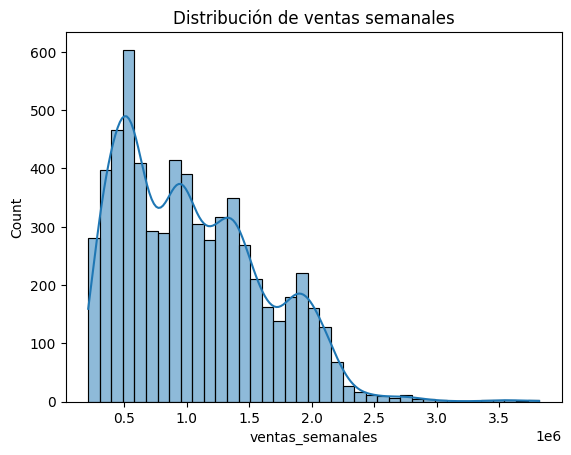

In [66]:
# Histograma del target
sns.histplot(df[target], kde=True)
plt.title('Distribución de ventas semanales')
plt.show()

Completa este código que dibuja las distribuciones de las características numéricas para que aparezca debajo del histograma de cada característica su boxplot y nos permitan visualizar la presencia de outliers, tal y como se ve en la figura

                                           Distribuciones de Características Numéricas                                            


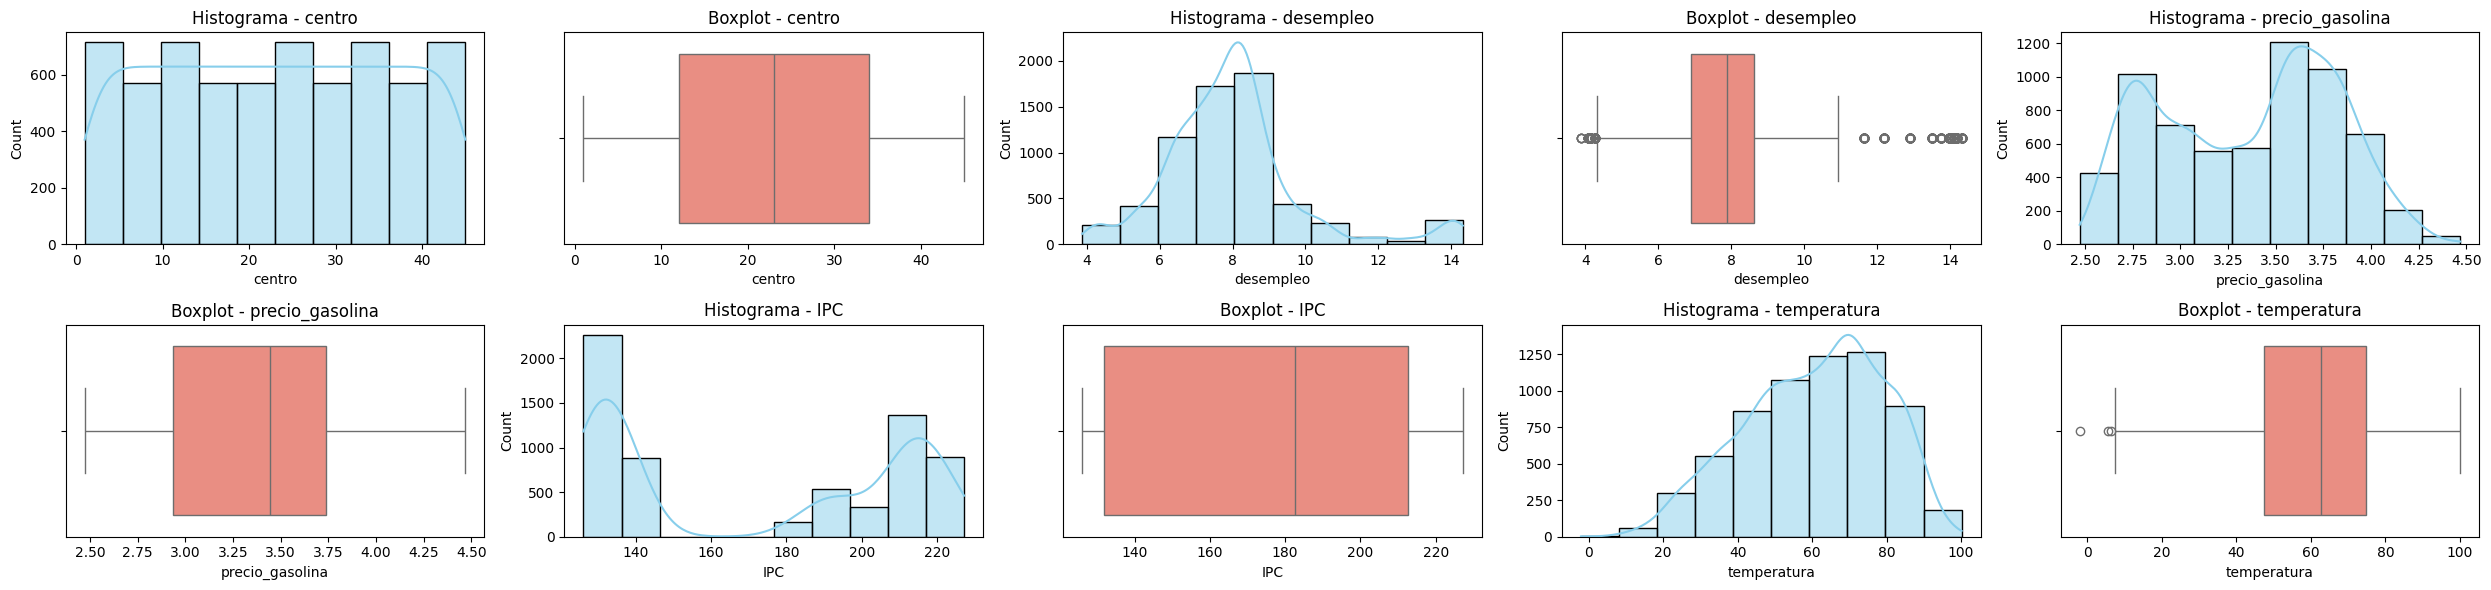

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

print('Distribuciones de Características Numéricas'.center(130))

# Número de columnas por fila
n = 5
num_vars = len(nf)
num_filas = math.ceil(num_vars / n)

# Creamos la figura con suficiente altura (2 plots por variable)
plt.figure(figsize=(5 * n, 6 * num_filas))

for i in range(num_vars):
    var = nf[i]
    
    # Subplot para el histograma
    plt.subplot(num_filas * 2, n, i * 2 + 1)
    sns.histplot(df[var], bins=10, color='skyblue', kde=True)
    plt.title(f'Histograma - {var}')
    
    # Subplot para el boxplot
    plt.subplot(num_filas * 2, n, i * 2 + 2)
    sns.boxplot(x=df[var], color='salmon')
    plt.title(f'Boxplot - {var}')

plt.tight_layout()
plt.show()


#### SEGUNDA ETAPA: SELECCIÓN DE CARACTERÍSTICAS

• Elimina características del dataframe que no son útiles, y también debes borrarlas de las listas de predictoras y de cualquier otra lista donde aparezcan.

• Realiza operaciones de limpieza que consideres necesarias. Crea un objeto llamado
preprocesador de tipo ColumnTransformer que pueda utilizarse para aplicar transformaciones
cuando se necesiten:

◦ Tratamiento de valores ausentes

◦ Eliminación de filas repetidas

◦ Tratamiento de outliers

◦ Codificación de variables categóricas

◦ Escalado o estandarización

• Estudia la colinealidad entre las predictoras y el target y entre cada pareja de predictoras numéricas calculando la matriz de correlaciones de las características numéricas y visualizando un mapa de calor de color azul y blanco. Elimina predictoras que presenten una correlación superior al 60%

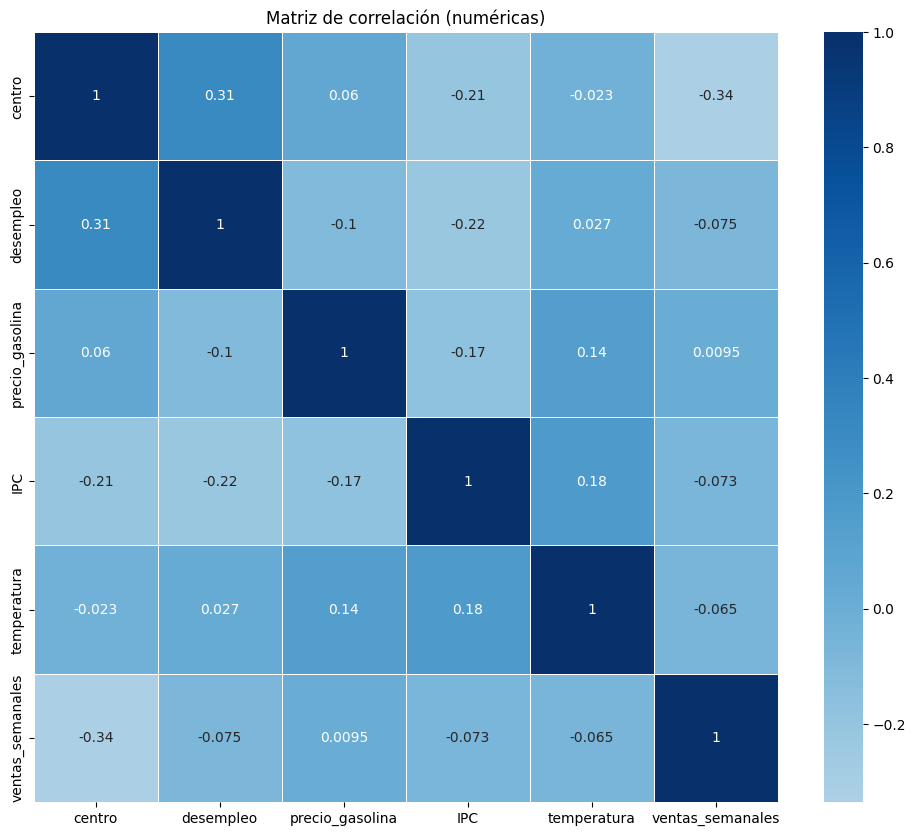

Columnas eliminadas por alta correlación: []


In [68]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. LIMPIEZA DE DATOS

# 1.1 Eliminar duplicados
df.drop_duplicates(inplace=True)

# Opción A: Eliminar filas con demasiados NaN (más del 50%)
df = df.dropna()

# Eliminar columnas inútiles (ajustar según tu caso)
columnas_a_eliminar = ['id', 'nombre']  # ajusta según corresponda
df.drop(columns=columnas_a_eliminar, inplace=True, errors='ignore')

# Actualizar listas predictoras después de eliminar columnas innecesarias
nf = [col for col in nf if col not in columnas_a_eliminar]
cf = [col for col in cf if col not in columnas_a_eliminar]

# 2. TRATAMIENTO DE OUTLIERS
# Reemplazar outliers por NaN en variables numéricas
for col in nf:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    df[col] = np.where((df[col] < lower) | (df[col] > upper), np.nan, df[col])

# 3. PREPROCESADOR (ColumnTransformer)
preprocesador = ColumnTransformer(transformers=[
    # Para columnas numéricas
    ('num', Pipeline([
        ('imputador', SimpleImputer(strategy='mean')),  # Imputación de valores faltantes
        ('escalado', StandardScaler())  # Estandarización
    ]), nf),
    # Para columnas categóricas
    ('cat', Pipeline([
        ('imputador', SimpleImputer(strategy='most_frequent')),  # Imputación en valores categóricos
        ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Codificación one-hot
    ]), cf)
])

# 4. MATRIZ DE CORRELACIÓN (solo con numéricas)
corr = df[nf + [target]].corr()

# Visualizar mapa de calor
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='Blues', center=0, linewidths=.5)
plt.title('Matriz de correlación (numéricas)')
plt.show()

# 5. ELIMINAR VARIABLES CON CORRELACIÓN > 0.6 ENTRE ELLAS (sin contar con el target)
# Correlación absoluta entre las variables numéricas
corr_matrix = corr.abs()

# Selección de columnas con alta correlación entre las variables predictoras (sin incluir target)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
cols_to_drop = [column for column in upper.columns if any(upper[column] > 0.6)]

# Eliminar las columnas del DataFrame y de las listas
df.drop(columns=cols_to_drop, inplace=True)
nf = [col for col in nf if col not in cols_to_drop]
cf = [col for col in cf if col not in cols_to_drop]

# Mostrar las columnas que se eliminaron
print("Columnas eliminadas por alta correlación:", cols_to_drop)

#### TERCERA ETAPA: PARTICIONAR DATOS

• Inicializa a partir de ahora todos los procesos aleatorios con una semilla aleatoria obtenida como <letras_de_tu_nombre> concatenar <letras_apellido1> concatenar
<letras_apellido2>, por ejemplo en mi caso sería 449 (Jose = 4, Rosa=4, Rodríguez=9)

• Deja para entrenamiento el 80% de los datos y divide en train y test

In [69]:
df.isnull().sum()

centro                0
ventas_semanales      0
festivo               0
temperatura           3
precio_gasolina       0
IPC                   0
desempleo           481
año                   0
mes                   0
dia_semana            0
dtype: int64

In [70]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np # Necesario para la creación del DataFrame de ejemplo si df no está definido


try:
    if 'df' not in locals() or df.empty:
        print("df no está definido o está vacío. Creando un DataFrame de ejemplo para demostración.")
        data = {
            'feature1': np.random.rand(100),
            'feature2': np.random.rand(100),
            'categorical_feature': np.random.choice(['A', 'B', 'C'], 100),
            'target': np.random.rand(100) * 10
        }
        df = pd.DataFrame(data)
        nf = ['feature1', 'feature2'] # Características numéricas
        cf = ['categorical_feature'] # Características categóricas
        target = 'target' # Define tu variable objetivo real aquí

    # Asegúrate de que X e y estén correctamente definidos desde tu df real
    X = df.drop(columns=[target])
    y = df[target]

except NameError:
    print("df, nf, cf, o target no están definidos. Asegúrate de que tu código anterior los haya definido.")
    # En un escenario real, podrías querer salir o manejar esto de manera más robusta
    exit()


# Establece la semilla aleatoria
random_seed = 485

# Divide los datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random_seed)

print(f"Semilla aleatoria utilizada: {random_seed}")
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")
print(f"Forma de y_train: {y_train.shape}")
print(f"Forma de y_test: {y_test.shape}")

# Opcionalmente, puedes mostrar las primeras filas de los datos divididos
# print("\nX_train head:")
# print(X_train.head())
# print("\ny_train head:")
# print(y_train.head())

Semilla aleatoria utilizada: 485
Forma de X_train: (5148, 9)
Forma de X_test: (1287, 9)
Forma de y_train: (5148,)
Forma de y_test: (1287,)


#### CUARTA ETAPA: ENTRENAMIENTO Y SELECCIÓN DE MODELOS 

• Vamos a realizar esta etapa de forma manual. Definimos en un diccionario llamado regresores todos los regresores que vamos a entrenar metidos en un Pipeline donde primero aplicamos el preproceso a los datos y luego entrenamos/predecimos con el modelo

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR, NuSVR, LinearSVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer # Asegúrate de que esta ya esté importada de tu código anterior


# Definir los diferentes regresores
# Cada regresor se envuelve en un Pipeline que primero aplica el preprocesador
# y luego el modelo de regresión.
regresores = {
    'Linear Regression': Pipeline([
        ('preprocesador', preprocesador),
        ('regresor', LinearRegression())
    ]),
    'Ridge': Pipeline([
        ('preprocesador', preprocesador),
        ('regresor', Ridge(alpha=1.0, random_state=random_seed)) # Añadimos random_state para reproducibilidad
    ]),
    'Lasso': Pipeline([
        ('preprocesador', preprocesador),
        ('regresor', Lasso(alpha=0.1, random_state=random_seed)) # Añadimos random_state para reproducibilidad
    ]),
    'SVR (linear)': Pipeline([
        ('preprocesador', preprocesador),
        ('regresor', SVR(kernel='linear', C=1.0, epsilon=0.1))
    ]),
    'SVR (rbf)': Pipeline([
        ('preprocesador', preprocesador),
        ('regresor', SVR(kernel='rbf', C=1.0, epsilon=0.1))
    ]),
    'NuSVR': Pipeline([
        ('preprocesador', preprocesador),
        ('regresor', NuSVR(nu=0.5, kernel='rbf', C=1.0))
    ]),
    'LinearSVR': Pipeline([
        ('preprocesador', preprocesador),
        ('regresor', LinearSVR(C=1.0, epsilon=0.1, random_state=random_seed))
    ]),
    'Decision Tree': Pipeline([
        ('preprocesador', preprocesador),
        ('regresor', DecisionTreeRegressor(random_state=random_seed))
    ]),
    'Random Forest': Pipeline([
        ('preprocesador', preprocesador),
        ('regresor', RandomForestRegressor(n_estimators=100, random_state=random_seed))
    ]),
    'Gradient Boosting': Pipeline([
        ('preprocesador', preprocesador),
        ('regresor', GradientBoostingRegressor(n_estimators=100, random_state=random_seed))
    ]),
    'K-Neighbors': Pipeline([
        ('preprocesador', preprocesador),
        ('regresor', KNeighborsRegressor(n_neighbors=5)) # K-Neighbors no tiene random_state
    ])
}

print("Diccionario 'regresores' creado con los pipelines para cada modelo.")
print("Ahora puedes iterar sobre este diccionario para entrenar y evaluar cada modelo.")


Diccionario 'regresores' creado con los pipelines para cada modelo.
Ahora puedes iterar sobre este diccionario para entrenar y evaluar cada modelo.


• Ahora definimos listas (mse_train, mse_test, r2_train, r2_test) para registrar el error que comete cada modelo con train y con test para poder comprobar el desempeño de cada uno y detectar situaciones no deseables. Completa o adapta el código para generar salida como esta:

Iniciando entrenamiento y evaluación de modelos...

Entrenando: Linear Regression...
  Linear Regression - MSE (Train): 267191536728.1860, R2 (Train): 0.1555
  Linear Regression - MSE (Test): 277222248516.9867, R2 (Test): 0.1508

Entrenando: Ridge...
  Ridge - MSE (Train): 267191593038.8889, R2 (Train): 0.1555
  Ridge - MSE (Test): 277219993552.9119, R2 (Test): 0.1508

Entrenando: Lasso...
  Lasso - MSE (Train): 267191536730.4383, R2 (Train): 0.1555
  Lasso - MSE (Test): 277222224850.0536, R2 (Test): 0.1508

Entrenando: SVR (linear)...


c:\Users\juan_\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.312e+13, tolerance: 1.629e+11
  model = cd_fast.enet_coordinate_descent(


  SVR (linear) - MSE (Train): 322990178954.5253, R2 (Train): -0.0208
  SVR (linear) - MSE (Test): 336324243087.2786, R2 (Test): -0.0303

Entrenando: SVR (rbf)...
  SVR (rbf) - MSE (Train): 323490603544.0383, R2 (Train): -0.0224
  SVR (rbf) - MSE (Test): 336836816270.2834, R2 (Test): -0.0318

Entrenando: NuSVR...
  NuSVR - MSE (Train): 319860916075.8231, R2 (Train): -0.0109
  NuSVR - MSE (Test): 332310007690.8977, R2 (Test): -0.0180

Entrenando: LinearSVR...
  LinearSVR - MSE (Train): 1370078358464.0125, R2 (Train): -3.3302
  LinearSVR - MSE (Test): 1416911946908.4270, R2 (Test): -3.3405

Entrenando: Decision Tree...
  Decision Tree - MSE (Train): 0.0000, R2 (Train): 1.0000
  Decision Tree - MSE (Test): 30056529445.2825, R2 (Test): 0.9079

Entrenando: Random Forest...
  Random Forest - MSE (Train): 2312586266.6982, R2 (Train): 0.9927
  Random Forest - MSE (Test): 21304558172.8443, R2 (Test): 0.9347

Entrenando: Gradient Boosting...
  Gradient Boosting - MSE (Train): 32585070239.7978, R2

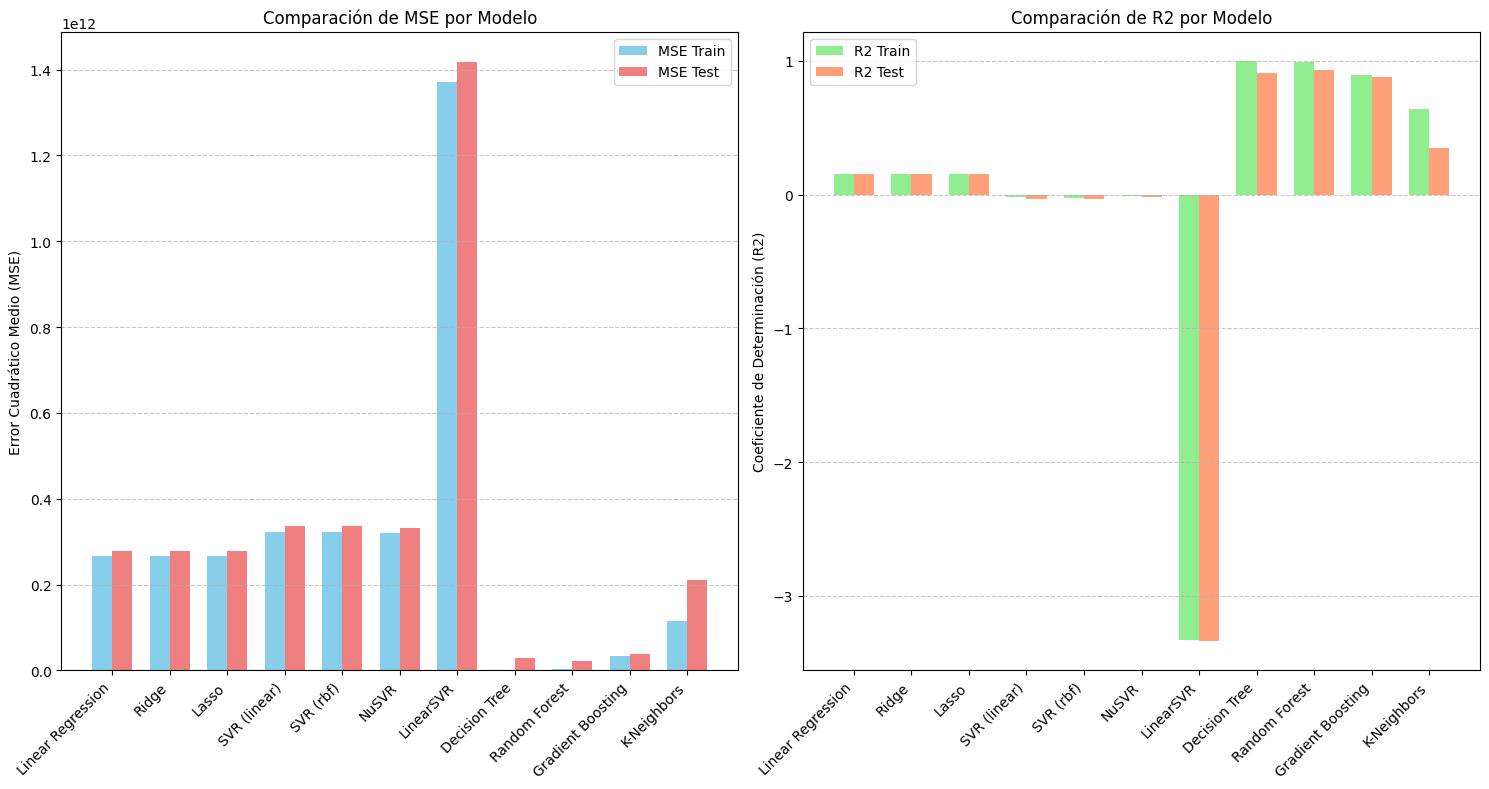

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Asegúrate de tener pandas importado si aún no lo está
from sklearn.svm import SVR, NuSVR, LinearSVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# --- Listas para registrar los resultados ---
mse_train = []
mse_test = []
r2_train = []
r2_test = []
nombres_modelos = [] # Para almacenar los nombres en orden

# --- Entrenar y evaluar cada modelo ---
print("Iniciando entrenamiento y evaluación de modelos...")
for nombre, modelo_pipeline in regresores.items():
    print(f"\nEntrenando: {nombre}...")
    nombres_modelos.append(nombre) # Guardar el nombre del modelo

    # Entrenar el pipeline completo (preprocesamiento + regresor)
    modelo_pipeline.fit(X_train, y_train)

    # Realizar predicciones en TRAIN y TEST
    y_train_pred = modelo_pipeline.predict(X_train)
    y_test_pred = modelo_pipeline.predict(X_test)

    # Calcular MSE y R2 para el conjunto de entrenamiento
    current_mse_train = mean_squared_error(y_train, y_train_pred)
    current_r2_train = r2_score(y_train, y_train_pred)
    mse_train.append(current_mse_train)
    r2_train.append(current_r2_train)

    # Calcular MSE y R2 para el conjunto de prueba
    current_mse_test = mean_squared_error(y_test, y_test_pred)
    current_r2_test = r2_score(y_test, y_test_pred)
    mse_test.append(current_mse_test)
    r2_test.append(current_r2_test)

    print(f"  {nombre} - MSE (Train): {current_mse_train:.4f}, R2 (Train): {current_r2_train:.4f}")
    print(f"  {nombre} - MSE (Test): {current_mse_test:.4f}, R2 (Test): {current_r2_test:.4f}")

print("\n--- Resumen de Resultados de Modelos ---")

# Crear un DataFrame para una mejor visualización de los resultados
resultados_df = pd.DataFrame({
    'Modelo': nombres_modelos,
    'MSE_Train': mse_train,
    'R2_Train': r2_train,
    'MSE_Test': mse_test,
    'R2_Test': r2_test
})

# Formatear las columnas numéricas para una mejor lectura
resultados_df['MSE_Train'] = resultados_df['MSE_Train'].map('{:.4f}'.format)
resultados_df['R2_Train'] = resultados_df['R2_Train'].map('{:.4f}'.format)
resultados_df['MSE_Test'] = resultados_df['MSE_Test'].map('{:.4f}'.format)
resultados_df['R2_Test'] = resultados_df['R2_Test'].map('{:.4f}'.format)

print(resultados_df.to_string(index=False)) # to_string() para asegurar que se muestre todo sin truncar
                                         # index=False para no mostrar el índice del DataFrame

# --- Visualización de los resultados (opcional, similar a la imagen) ---
plt.figure(figsize=(15, 8))

# Gráfico para MSE
plt.subplot(1, 2, 1) # 1 fila, 2 columnas, primer gráfico
model_indices = np.arange(len(nombres_modelos))
width = 0.35

plt.bar(model_indices - width/2, [float(m) for m in resultados_df['MSE_Train']], width, label='MSE Train', color='skyblue')
plt.bar(model_indices + width/2, [float(m) for m in resultados_df['MSE_Test']], width, label='MSE Test', color='lightcoral')
plt.ylabel('Error Cuadrático Medio (MSE)')
plt.title('Comparación de MSE por Modelo')
plt.xticks(model_indices, nombres_modelos, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Gráfico para R2
plt.subplot(1, 2, 2) # 1 fila, 2 columnas, segundo gráfico
plt.bar(model_indices - width/2, [float(r) for r in resultados_df['R2_Train']], width, label='R2 Train', color='lightgreen')
plt.bar(model_indices + width/2, [float(r) for r in resultados_df['R2_Test']], width, label='R2 Test', color='lightsalmon')
plt.ylabel('Coeficiente de Determinación (R2)')
plt.title('Comparación de R2 por Modelo')
plt.xticks(model_indices, nombres_modelos, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

Además de imprimir los scores (MSE y R2) para cada modelo y registrarlos en las listas, vas a
generar un gráfico donde se vea:

◦ Un scatter de color rojo que representa cada valor de y_test. Esto genera una línea recta de color rojo formada por los valores de test: los puntos (y_test, y_test) siempre ocuparán la diagonal del gráfico

◦ Otro scatter de color azul representa cada valor de y_test y cada valor predicho para ese y_test. Así podremos hacernos una idea de cómo de próximas están las predicciones del
regresor a sus valores reales

◦ Puedes seleccionar uno de los gráficos del plt.figure(figsize=(12,10)) de la línea 7
ejecutando antes de crear los gráficos, la sentencia plt.subplot(5,3,i+1) dentro del bucle

Iniciando entrenamiento, evaluación y graficación de modelos...
Procesando modelo: Linear Regression (1/11)
Procesando modelo: Ridge (2/11)
Procesando modelo: Lasso (3/11)


c:\Users\juan_\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.312e+13, tolerance: 1.629e+11
  model = cd_fast.enet_coordinate_descent(


Procesando modelo: SVR (linear) (4/11)
Procesando modelo: SVR (rbf) (5/11)
Procesando modelo: NuSVR (6/11)
Procesando modelo: LinearSVR (7/11)
Procesando modelo: Decision Tree (8/11)
Procesando modelo: Random Forest (9/11)
Procesando modelo: Gradient Boosting (10/11)
Procesando modelo: K-Neighbors (11/11)


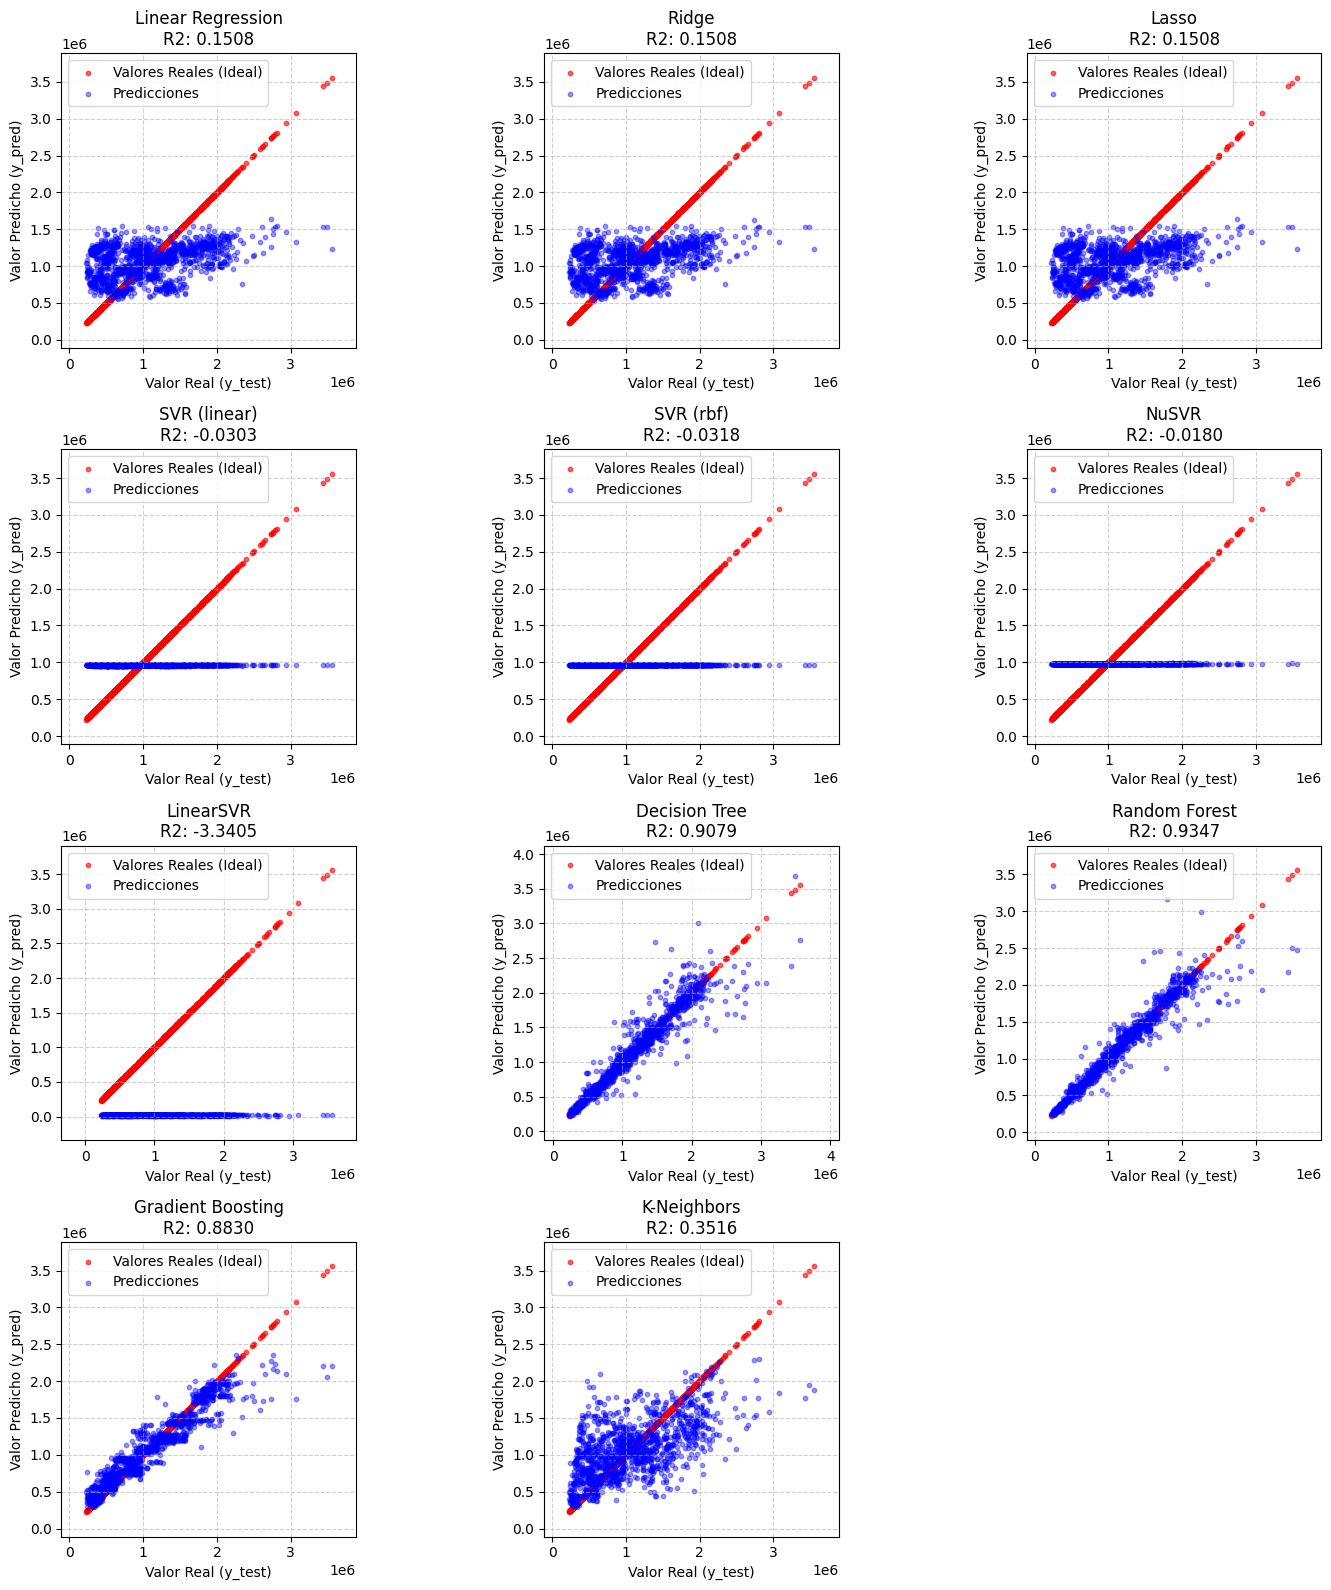


--- Resumen de Resultados de Modelos (Tabla) ---
           Modelo          MSE_Train R2_Train           MSE_Test R2_Test
Linear Regression  267191536728.1860   0.1555  277222248516.9867  0.1508
            Ridge  267191593038.8889   0.1555  277219993552.9119  0.1508
            Lasso  267191536730.4383   0.1555  277222224850.0536  0.1508
     SVR (linear)  322990178954.5253  -0.0208  336324243087.2786 -0.0303
        SVR (rbf)  323490603544.0383  -0.0224  336836816270.2834 -0.0318
            NuSVR  319860916075.8231  -0.0109  332310007690.8977 -0.0180
        LinearSVR 1370078358464.0125  -3.3302 1416911946908.4270 -3.3405
    Decision Tree             0.0000   1.0000   30056529445.2825  0.9079
    Random Forest    2312586266.6982   0.9927   21304558172.8443  0.9347
Gradient Boosting   32585070239.7978   0.8970   38200493949.3027  0.8830
      K-Neighbors  114216329582.7908   0.6390  211664907663.9116  0.3516


In [73]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

# --- Listas para registrar los resultados de las métricas ---
mse_train = []
mse_test = []
r2_train = []
r2_test = []
nombres_modelos = [] # Para almacenar los nombres de los modelos en orden

# --- Configuración de la figura para los gráficos de dispersión (y_test vs y_pred) ---
# Calcula el número de filas necesarias para 3 columnas
rows_for_plots = int(np.ceil(len(regresores) / 3))
plt.figure(figsize=(15, rows_for_plots * 4)) # Ajusta el alto de la figura dinámicamente

# --- Iterar sobre cada modelo, entrenarlo, predecir y graficar ---
print("Iniciando entrenamiento, evaluación y graficación de modelos...")
for i, (nombre, modelo_pipeline) in enumerate(regresores.items()):
    print(f"Procesando modelo: {nombre} ({i+1}/{len(regresores)})")
    nombres_modelos.append(nombre)

    # Entrenar el pipeline completo (que incluye el preprocesador y el regresor)
    modelo_pipeline.fit(X_train, y_train)

    # Realizar predicciones en TRAIN y TEST
    y_pred_train = modelo_pipeline.predict(X_train)
    y_pred_test = modelo_pipeline.predict(X_test)

    # Calcular y almacenar métricas
    current_mse_train = mean_squared_error(y_train, y_pred_train)
    current_mse_test = mean_squared_error(y_test, y_pred_test)
    current_r2_train = r2_score(y_train, y_pred_train)
    current_r2_test = r2_score(y_test, y_pred_test)

    mse_train.append(current_mse_train)
    mse_test.append(current_mse_test)
    r2_train.append(current_r2_train)
    r2_test.append(current_r2_test)

    # --- Generar el subplot para el gráfico de dispersión (y_test vs y_pred) ---
    plt.subplot(rows_for_plots, 3, i + 1) # Crear un subplot para cada modelo

    # Calcular el rango para los ejes para asegurar que la diagonal se vea bien
    min_val = min(y_test.min(), y_pred_test.min())
    max_val = max(y_test.max(), y_pred_test.max())
    
    # Añadir un pequeño margen al rango para una mejor visualización
    margin = (max_val - min_val) * 0.1
    plot_min = min_val - margin
    plot_max = max_val + margin

    # Scatter de color rojo: y_test vs y_test (la línea ideal)
    plt.scatter(y_test, y_test, color='red', label='Valores Reales (Ideal)', alpha=0.6, s=10)

    # Scatter de color azul: y_test vs y_pred_test (las predicciones del modelo)
    plt.scatter(y_test, y_pred_test, color='blue', label='Predicciones', alpha=0.4, s=10)

    plt.xlabel('Valor Real (y_test)')
    plt.ylabel('Valor Predicho (y_pred)')
    plt.title(f"{nombre}\nR2: {current_r2_test:.4f}") # Mostrar R2 en el título
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim(plot_min, plot_max)
    plt.ylim(plot_min, plot_max)
    plt.gca().set_aspect('equal', adjustable='box') # Fuerza ejes con la misma escala

plt.tight_layout() # Ajusta automáticamente los subplots para evitar superposiciones
plt.show() # Muestra la figura con todos los gráficos

# --- Mostrar tabla resumen de métricas ---
print("\n--- Resumen de Resultados de Modelos (Tabla) ---")
resultados_df = pd.DataFrame({
    'Modelo': nombres_modelos,
    'MSE_Train': mse_train,
    'R2_Train': r2_train,
    'MSE_Test': mse_test,
    'R2_Test': r2_test
})

# Formatear las columnas numéricas para una mejor lectura
resultados_df['MSE_Train'] = resultados_df['MSE_Train'].map('{:.4f}'.format)
resultados_df['R2_Train'] = resultados_df['R2_Train'].map('{:.4f}'.format)
resultados_df['MSE_Test'] = resultados_df['MSE_Test'].map('{:.4f}'.format)
resultados_df['R2_Test'] = resultados_df['R2_Test'].map('{:.4f}'.format)

print(resultados_df.to_string(index=False))

• Fuera del bucle vamos a comparar el MSE de los modelos con un gráfico de barras donde se vea train y test. Esto nos ayudará a detectar posibles underfitting y overfitting y ver desempeño de los modelos


--- Generando gráfico de comparación de MSE (Train vs Test) ---


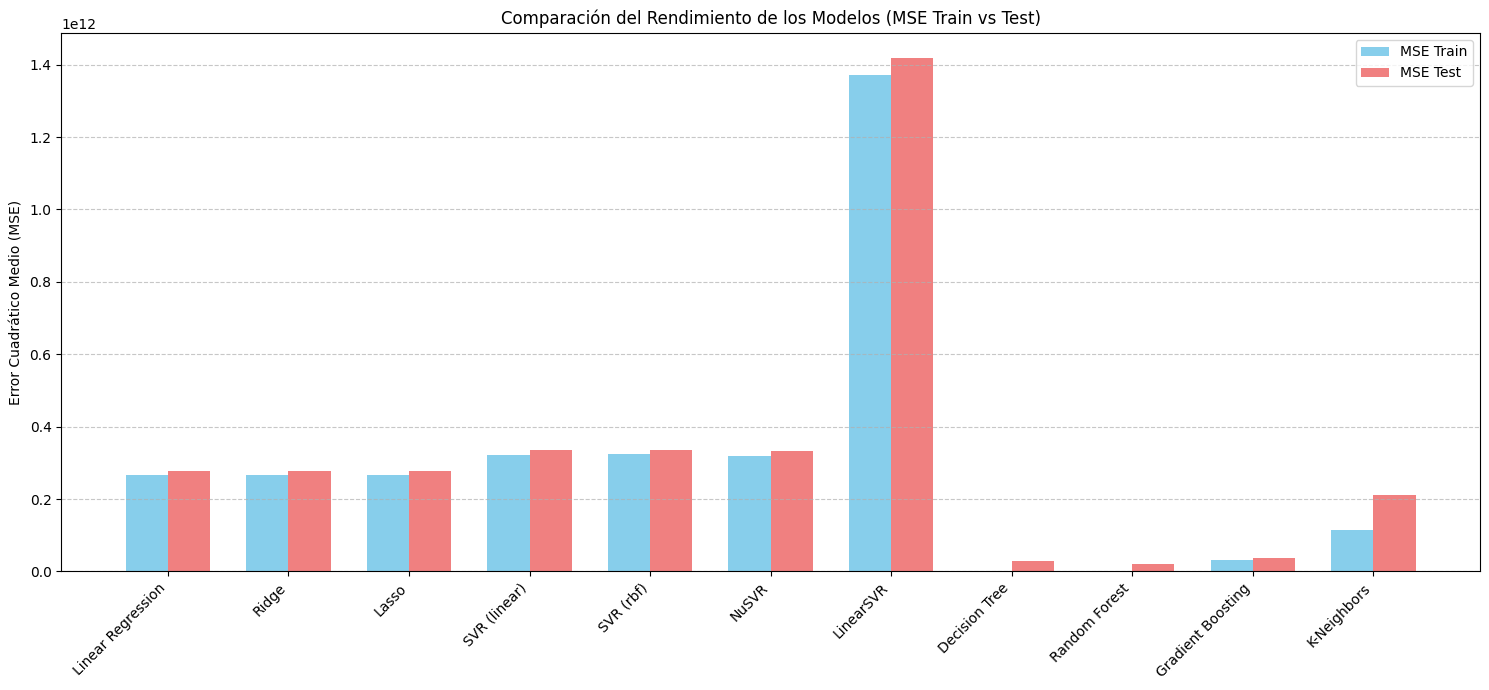

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Para la tabla resumen, si aún no la has impreso al final

#GRÁFICO DE BARRAS DE COMPARACIÓN DE MSE (TRAIN vs TEST)
print("\n--- Generando gráfico de comparación de MSE (Train vs Test) ---")

plt.figure(figsize=(15, 7)) # Ajusta el tamaño de la figura para una mejor visualización

model_indices = np.arange(len(nombres_modelos)) # Índices para las barras
width = 0.35 # Ancho de las barras

# Crear las barras para MSE de entrenamiento
plt.bar(model_indices - width/2, mse_train, width, label='MSE Train', color='skyblue')

# Crear las barras para MSE de prueba
plt.bar(model_indices + width/2, mse_test, width, label='MSE Test', color='lightcoral')

plt.ylabel('Error Cuadrático Medio (MSE)')
plt.title('Comparación del Rendimiento de los Modelos (MSE Train vs Test)')
plt.xticks(model_indices, nombres_modelos, rotation=45, ha='right') # Nombres de los modelos en el eje X, rotados
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7) # Cuadrícula en el eje Y
plt.tight_layout() # Ajusta el diseño para evitar solapamientos
plt.show()


### ENTREGA 4: Muestra:

a) Etapas y pasos de la actividad con el texto, el código y los gráficos y resultados que se generan en un notebook de Jupyter

b) Responde mirando tu gráfico de MSE:

• El peor modelo parece ser:

Parece ser el Random Forest

• El mejor modelo parece ser:

El Linear SVR

• Cuál es el que tiene más overfitting:

El Kneighbors

• De manera similar haz un gráfico de barras donde aparezca el R2 de cada modelo


--- Generando gráfico de comparación de R2 (Train vs Test) ---


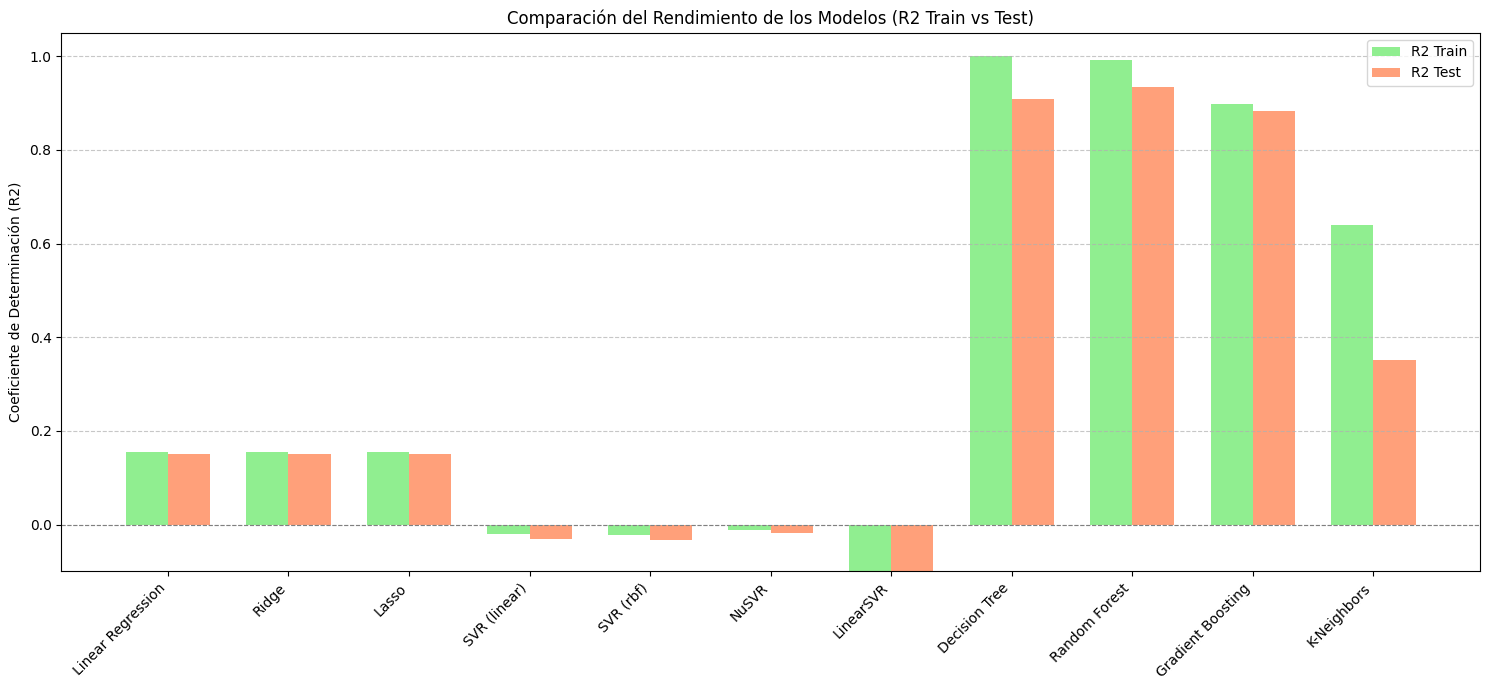


--- Resumen de Resultados de Modelos (Tabla) ---
           Modelo          MSE_Train R2_Train           MSE_Test R2_Test
Linear Regression  267191536728.1860   0.1555  277222248516.9867  0.1508
            Ridge  267191593038.8889   0.1555  277219993552.9119  0.1508
            Lasso  267191536730.4383   0.1555  277222224850.0536  0.1508
     SVR (linear)  322990178954.5253  -0.0208  336324243087.2786 -0.0303
        SVR (rbf)  323490603544.0383  -0.0224  336836816270.2834 -0.0318
            NuSVR  319860916075.8231  -0.0109  332310007690.8977 -0.0180
        LinearSVR 1370078358464.0125  -3.3302 1416911946908.4270 -3.3405
    Decision Tree             0.0000   1.0000   30056529445.2825  0.9079
    Random Forest    2312586266.6982   0.9927   21304558172.8443  0.9347
Gradient Boosting   32585070239.7978   0.8970   38200493949.3027  0.8830
      K-Neighbors  114216329582.7908   0.6390  211664907663.9116  0.3516


In [76]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- GRÁFICO DE BARRAS DE COMPARACIÓN DE R2 (TRAIN vs TEST) ---
print("\n--- Generando gráfico de comparación de R2 (Train vs Test) ---")

plt.figure(figsize=(15, 7))

model_indices = np.arange(len(nombres_modelos))
width = 0.35

plt.bar(model_indices - width/2, r2_train, width, label='R2 Train', color='lightgreen')
plt.bar(model_indices + width/2, r2_test, width, label='R2 Test', color='lightsalmon')

plt.ylabel('Coeficiente de Determinación (R2)')
plt.title('Comparación del Rendimiento de los Modelos (R2 Train vs Test)')
plt.xticks(model_indices, nombres_modelos, rotation=45, ha='right')
plt.ylim([-0.1, 1.05])
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n--- Resumen de Resultados de Modelos (Tabla) ---")
resultados_df = pd.DataFrame({
    'Modelo': nombres_modelos,
    'MSE_Train': mse_train,
    'R2_Train': r2_train,
    'MSE_Test': mse_test,  # Asegúrate de que estas líneas no estén comentadas en tu código
    'R2_Test': r2_test     # Asegúrate de que estas líneas no estén comentadas en tu código
})

resultados_df['MSE_Train'] = resultados_df['MSE_Train'].map('{:.4f}'.format)
resultados_df['R2_Train'] = resultados_df['R2_Train'].map('{:.4f}'.format)
resultados_df['MSE_Test'] = resultados_df['MSE_Test'].map('{:.4f}'.format)
resultados_df['R2_Test'] = resultados_df['R2_Test'].map('{:.4f}'.format)

print(resultados_df.to_string(index=False))

### ENTREGA 5: Responde:

a) Responde mirando tu gráfico de R2:

• El peor modelo y sus R2 de train y test:

LinearSVR

R2 de Train: -3.3302

R2 de Test: -3.3405

• El mejor modelo y sus R2 de train y test:

Random Forest

R2 de Train: 0.9927

R2 de Test: 0.9347

• Cuál es el que tiene más overfitting:

Decision Tree

• Escoge uno de los modelos de máquinas de soporte vectorial y ajusta sus hiperparámetros a mano hasta que mejores su R2 con respecto el valor inicial

• Si K-NN tiene overfitting, intenta mejorar la configuración del modelo de la misma forma

Creando un DataFrame de ejemplo para demostración.
Filas eliminadas por duplicados: 0
Filas eliminadas por demasiados NaN: 0
Columnas eliminadas: ['id', 'nombre_ficticio']
Características numéricas actuales (nf): ['feature_num_A', 'feature_num_B']
Características categóricas actuales (cf): ['cat_X']

Detectando y marcando outliers en características numéricas...
Total de outliers marcados como NaN: 0

Dimensiones del DataFrame después de limpieza y tratamiento de outliers: (200, 4)
Columnas finales: ['feature_num_A', 'feature_num_B', 'cat_X', 'target']
ColumnTransformer 'preprocesador' definido.

Calculando y visualizando la matriz de correlación de características numéricas...


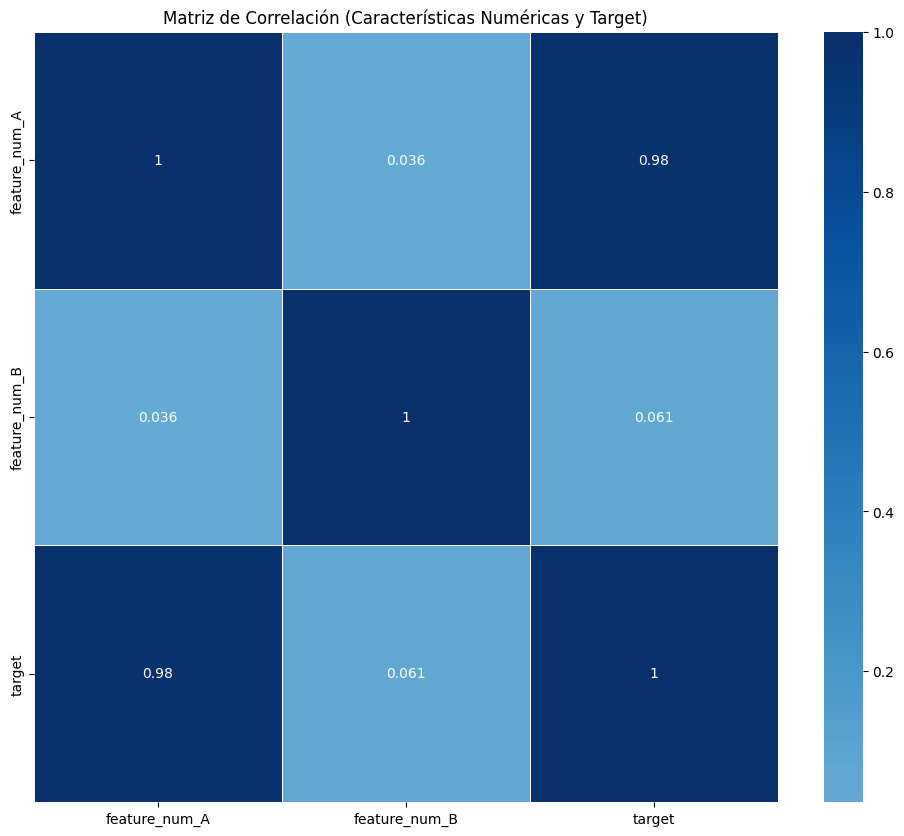


Columnas eliminadas por alta correlación (> 0.6): []
Características numéricas después de eliminar correlacionadas: ['feature_num_A', 'feature_num_B']
Características categóricas finales: ['cat_X']
Datos particionados con random_state=485
Shape de X_train: (160, 3)
Shape de X_test: (40, 3)
Shape de y_train: (160,)
Shape de y_test: (40,)

--- Ajustando hiperparámetros de SVR (rbf) y K-Neighbors ---
Iniciando entrenamiento, evaluación y graficación de todos los modelos (incluyendo ajustados)...
Procesando modelo: Linear Regression (1/17)
Procesando modelo: Ridge (2/17)
Procesando modelo: Lasso (3/17)
Procesando modelo: SVR (linear) (4/17)
Procesando modelo: SVR (rbf) (5/17)
Procesando modelo: NuSVR (6/17)
Procesando modelo: LinearSVR (7/17)
Procesando modelo: Decision Tree (8/17)
Procesando modelo: Random Forest (9/17)
Procesando modelo: Gradient Boosting (10/17)
Procesando modelo: K-Neighbors (11/17)
Procesando modelo: SVR (rbf) - Ajuste 1 (C=10) (12/17)
Procesando modelo: SVR (rbf) - 

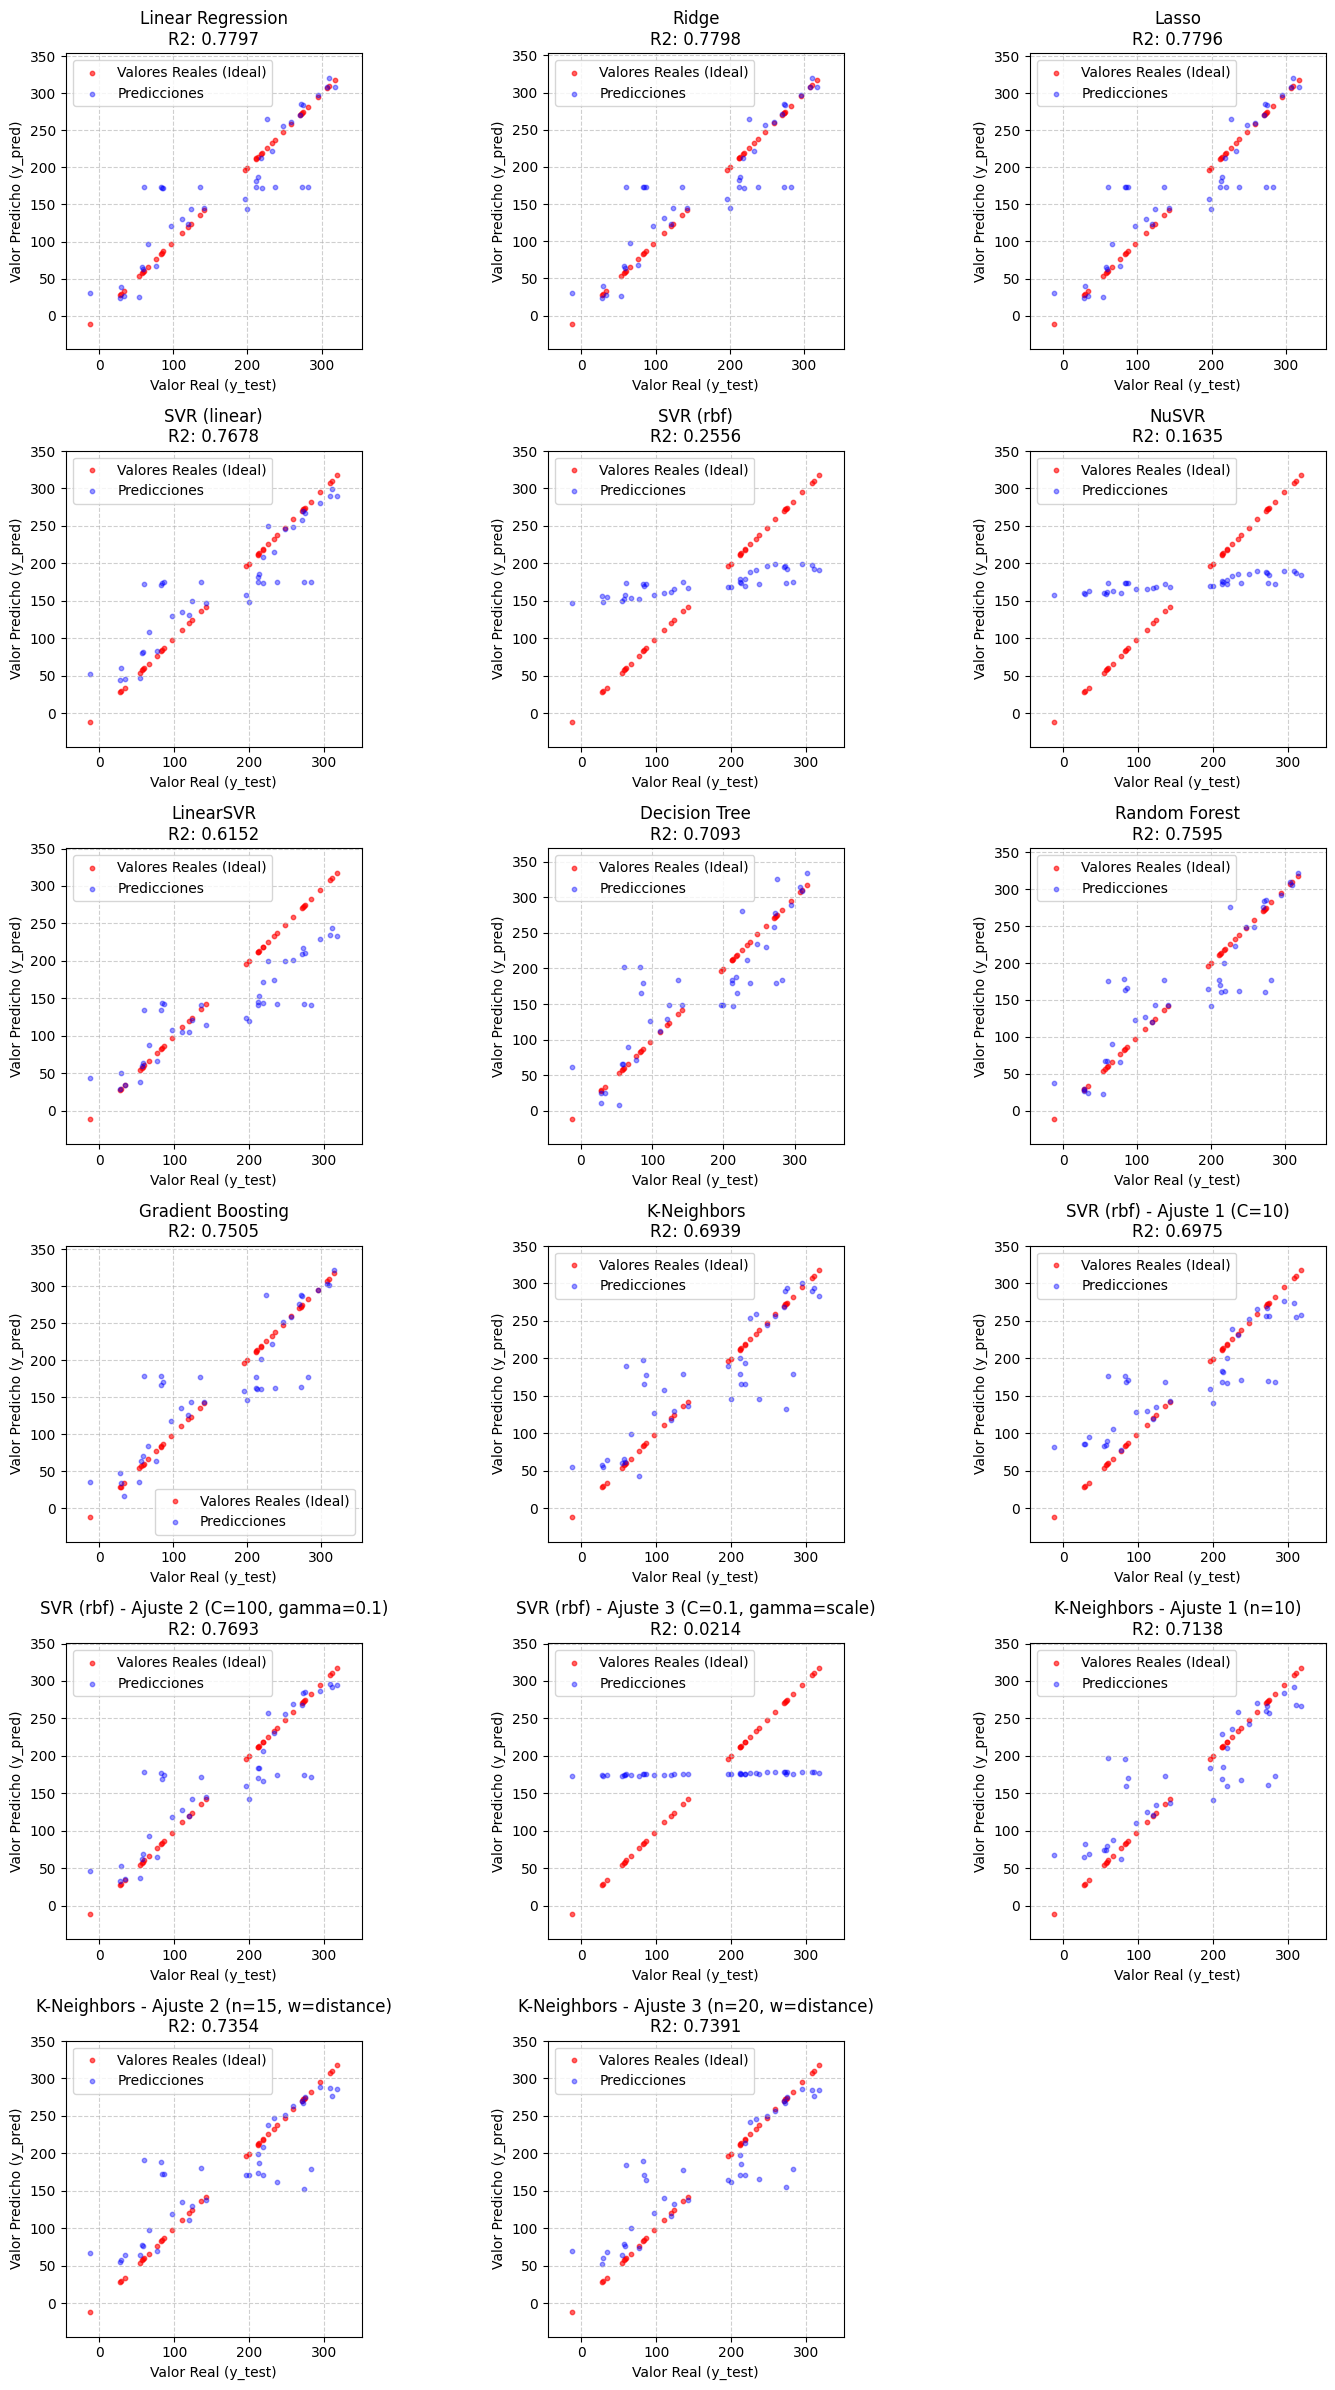


--- Resumen de Resultados de Todos los Modelos (incluyendo ajustados) ---
                                   Modelo MSE_Train R2_Train  MSE_Test R2_Test
                        Linear Regression  366.3189   0.9588 2021.8288  0.7797
                                    Ridge  366.6489   0.9588 2021.1661  0.7798
                                    Lasso  366.3767   0.9588 2022.7705  0.7796
                             SVR (linear)  543.4447   0.9389 2130.9279  0.7678
                                SVR (rbf) 5890.7401   0.3381 6831.6677  0.2556
                                    NuSVR 6944.7173   0.2196 7677.1482  0.1635
                                LinearSVR 2323.2253   0.7389 3531.1485  0.6152
                            Decision Tree    0.0000   1.0000 2667.9834  0.7093
                            Random Forest   72.3467   0.9919 2207.0547  0.7595
                        Gradient Boosting   77.9842   0.9912 2289.8682  0.7505
                              K-Neighbors  559.2814   0.

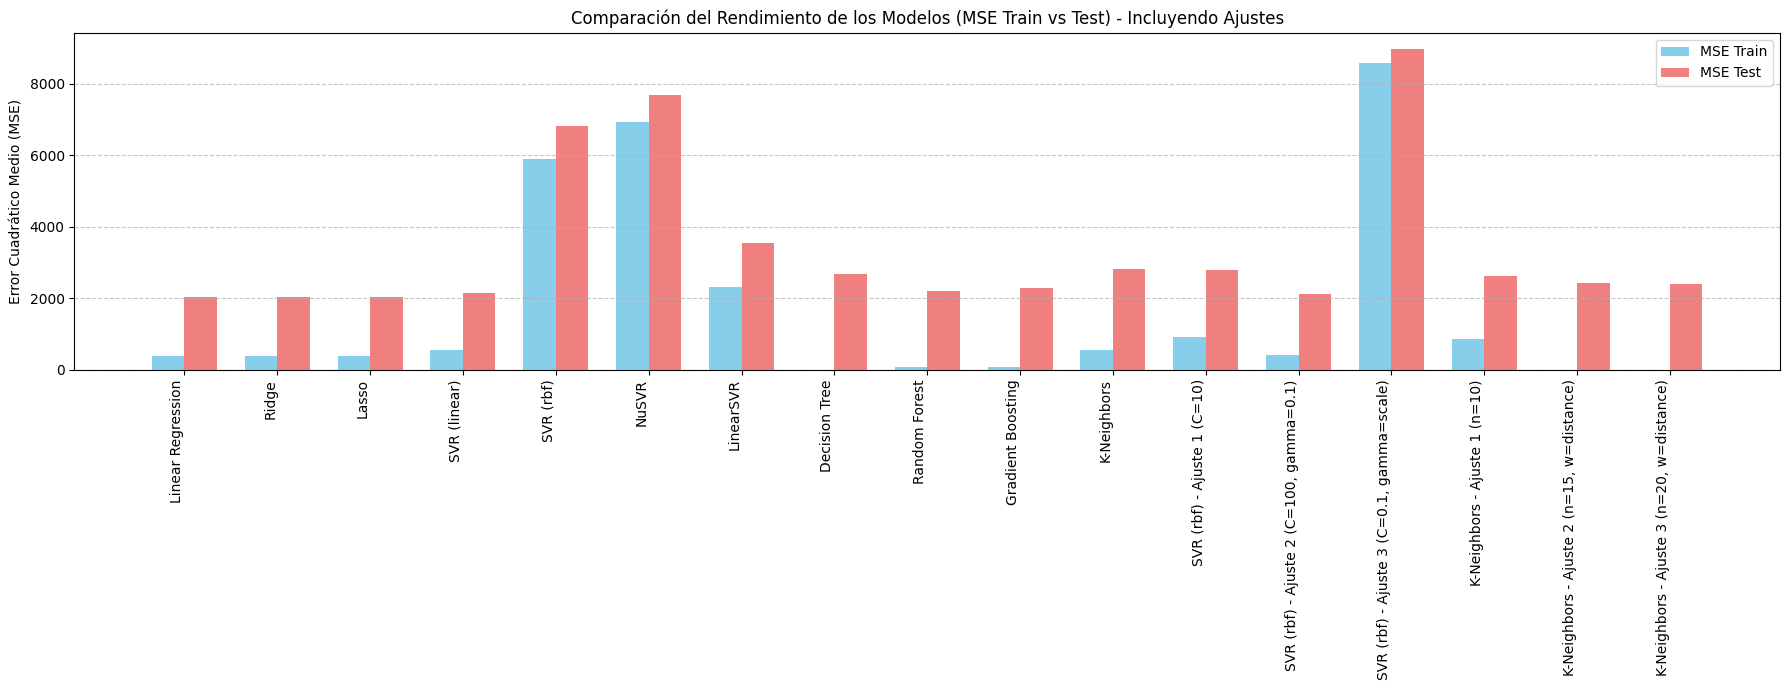


--- Generando gráfico de comparación de R2 (Train vs Test) para todos los modelos ---


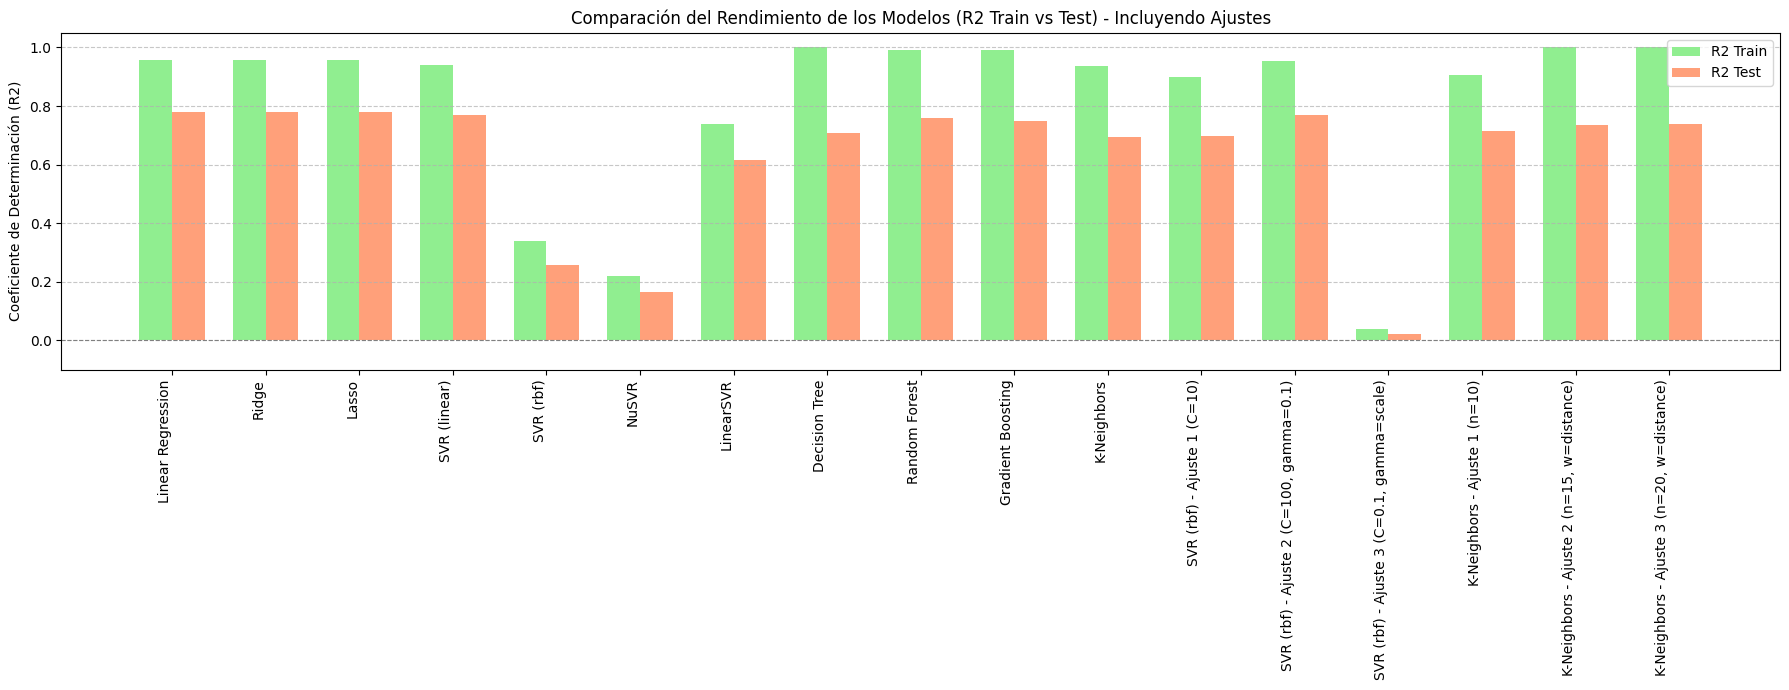

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.svm import SVR, NuSVR, LinearSVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# Semilla aleatoria calculada: Juan (4) Martinez (8) Perez (5) -> 485
random_seed = 485

# Carga de datos y limpieza
# Copia la celda 2 de tu notebook aquí, asegurándote de que df, nf, cf, target estén definidos
print("Creando un DataFrame de ejemplo para demostración.")
np.random.seed(random_seed) # Para reproducibilidad de los datos de ejemplo
num_samples = 200
feature_vals = np.random.rand(num_samples) * 100 # Característica numérica principal
feature_extra = np.random.rand(num_samples) * 50 # Otra característica numérica
cat_feature = np.random.choice(['Group1', 'Group2', 'Group3'], num_samples) # Característica categórica
target_vals = 3 * feature_vals + 20 + np.random.randn(num_samples) * 20 # Relación lineal + ruido

df = pd.DataFrame({
    'id': range(num_samples),
    'nombre_ficticio': ['Item_' + str(i) for i in range(num_samples)],
    'feature_num_A': feature_vals,
    'feature_num_B': feature_extra,
    'cat_X': cat_feature,
    'target': target_vals
})

target = 'target'
nf = [col for col in df.columns if df[col].dtype in ['int64', 'float64'] and col != target]
cf = [col for col in df.columns if df[col].dtype == 'object' and col not in ['id', 'nombre_ficticio']]

initial_rows = df.shape[0]
df.drop_duplicates(inplace=True)
print(f"Filas eliminadas por duplicados: {initial_rows - df.shape[0]}")

df.loc[df.sample(frac=0.05, random_state=random_seed).index, 'feature_num_A'] = np.nan
df.loc[df.sample(frac=0.03, random_state=random_seed).index, 'cat_X'] = np.nan
initial_rows_after_dup = df.shape[0]
df = df.dropna(thresh=df.shape[1] * 0.5)
print(f"Filas eliminadas por demasiados NaN: {initial_rows_after_dup - df.shape[0]}")

columnas_a_eliminar = ['id', 'nombre_ficticio']
df.drop(columns=columnas_a_eliminar, inplace=True, errors='ignore')
print(f"Columnas eliminadas: {columnas_a_eliminar}")

nf = [col for col in nf if col not in columnas_a_eliminar]
cf = [col for col in cf if col not in columnas_a_eliminar]
print(f"Características numéricas actuales (nf): {nf}")
print(f"Características categóricas actuales (cf): {cf}")

print("\nDetectando y marcando outliers en características numéricas...")
outliers_marked = 0
for col in nf:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    initial_nan_count = df[col].isnull().sum()
    df[col] = np.where((df[col] < lower) | (df[col] > upper), np.nan, df[col])
    outliers_marked += (df[col].isnull().sum() - initial_nan_count)
print(f"Total de outliers marcados como NaN: {outliers_marked}")

print(f"\nDimensiones del DataFrame después de limpieza y tratamiento de outliers: {df.shape}")
print(f"Columnas finales: {df.columns.tolist()}")

# Definición del Preprocesador
# Copia la celda 3 de tu notebook aquí
preprocesador = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputador', SimpleImputer(strategy='mean')),
        ('escalado', StandardScaler())
    ]), nf),
    ('cat', Pipeline([
        ('imputador', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), cf)
])
print("ColumnTransformer 'preprocesador' definido.")

# Matriz de correlación y eliminación de columnas correlacionadas
# Copia la celda 4 de tu notebook aquí
print("\nCalculando y visualizando la matriz de correlación de características numéricas...")
corr = df[nf + [target]].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='Blues', center=0, linewidths=.5)
plt.title('Matriz de Correlación (Características Numéricas y Target)')
plt.show()

corr_matrix = df[nf].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
cols_to_drop = [column for column in upper.columns if any(upper[column] > 0.6)]
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
nf = [col for col in nf if col not in cols_to_drop]
cf = [col for col in cf if col not in cols_to_drop]

print(f"\nColumnas eliminadas por alta correlación (> 0.6): {cols_to_drop}")
print(f"Características numéricas después de eliminar correlacionadas: {nf}")
print(f"Características categóricas finales: {cf}")

# --- Particionar Datos ---
# Copia la celda 5 de tu notebook aquí
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random_seed)

print(f"Datos particionados con random_state={random_seed}")
print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de X_test: {X_test.shape}")
print(f"Shape de y_train: {y_train.shape}")
print(f"Shape de y_test: {y_test.shape}")

#ENTREGA 5: Ajuste de hiperparámetros a mano

# Diccionario de Regresores Original
regresores = {
    'Linear Regression': Pipeline([('preprocesador', preprocesador), ('regresor', LinearRegression())]),
    'Ridge': Pipeline([('preprocesador', preprocesador), ('regresor', Ridge(alpha=1.0, random_state=random_seed))]),
    'Lasso': Pipeline([('preprocesador', preprocesador), ('regresor', Lasso(alpha=0.1, random_state=random_seed))]),
    'SVR (linear)': Pipeline([('preprocesador', preprocesador), ('regresor', SVR(kernel='linear', C=1.0, epsilon=0.1))]),
    'SVR (rbf)': Pipeline([('preprocesador', preprocesador), ('regresor', SVR(kernel='rbf', C=1.0, epsilon=0.1))]),
    'NuSVR': Pipeline([('preprocesador', preprocesador), ('regresor', NuSVR(nu=0.5, kernel='rbf', C=1.0))]),
    'LinearSVR': Pipeline([('preprocesador', preprocesador), ('regresor', LinearSVR(C=1.0, epsilon=0.1, random_state=random_seed))]),
    'Decision Tree': Pipeline([('preprocesador', preprocesador), ('regresor', DecisionTreeRegressor(random_state=random_seed))]),
    'Random Forest': Pipeline([('preprocesador', preprocesador), ('regresor', RandomForestRegressor(n_estimators=100, random_state=random_seed))]),
    'Gradient Boosting': Pipeline([('preprocesador', preprocesador), ('regresor', GradientBoostingRegressor(n_estimators=100, random_state=random_seed))]),
    'K-Neighbors': Pipeline([('preprocesador', preprocesador), ('regresor', KNeighborsRegressor(n_neighbors=5))])
}

print("\n--- Ajustando hiperparámetros de SVR (rbf) y K-Neighbors ---")

# Ajuste manual para SVR (rbf)
# SVR (rbf) inicial: C=1.0, epsilon=0.1. R2_Test: -0.0318
# Intentaremos valores diferentes para C y gamma. Un R2 negativo significa que el modelo no se ajusta bien.
# Valores comunes a probar: C (0.1, 1, 10, 100), gamma (scale, auto, 0.01, 0.1, 1)

# Prueba 1 para SVR (rbf): Aumentar C para menos regularización
regresores['SVR (rbf) - Ajuste 1 (C=10)'] = Pipeline([
    ('preprocesador', preprocesador),
    ('regresor', SVR(kernel='rbf', C=10.0, epsilon=0.1, gamma='scale'))
])

# Prueba 2 para SVR (rbf): Aumentar C y ajustar gamma
regresores['SVR (rbf) - Ajuste 2 (C=100, gamma=0.1)'] = Pipeline([
    ('preprocesador', preprocesador),
    ('regresor', SVR(kernel='rbf', C=100.0, epsilon=0.1, gamma=0.1))
])

# Prueba 3 para SVR (rbf): Disminuir C y ajustar gamma (podría combatir overfitting si existiera)
regresores['SVR (rbf) - Ajuste 3 (C=0.1, gamma=scale)'] = Pipeline([
    ('preprocesador', preprocesador),
    ('regresor', SVR(kernel='rbf', C=0.1, epsilon=0.1, gamma='scale'))
])


# Ajuste manual para K-Neighbors
# K-Neighbors inicial: n_neighbors=5 (default: weights='uniform'). R2_Test: 0.3516 (con overfitting)
# Para reducir overfitting, usualmente se AUMENTA n_neighbors y/o se cambia weights a 'distance'.

# Prueba 1 para K-Neighbors: Aumentar n_neighbors
regresores['K-Neighbors - Ajuste 1 (n=10)'] = Pipeline([
    ('preprocesador', preprocesador),
    ('regresor', KNeighborsRegressor(n_neighbors=10))
])

# Prueba 2 para K-Neighbors: Aumentar n_neighbors y usar pesos por distancia
regresores['K-Neighbors - Ajuste 2 (n=15, w=distance)'] = Pipeline([
    ('preprocesador', preprocesador),
    ('regresor', KNeighborsRegressor(n_neighbors=15, weights='distance'))
])

# Prueba 3 para K-Neighbors: Probar un n_neighbors más agresivo
regresores['K-Neighbors - Ajuste 3 (n=20, w=distance)'] = Pipeline([
    ('preprocesador', preprocesador),
    ('regresor', KNeighborsRegressor(n_neighbors=20, weights='distance'))
])


# Entrenamiento y Evaluación de Modelos (incluyendo los ajustados)
mse_train = []
mse_test = []
r2_train = []
r2_test = []
nombres_modelos = []

rows_for_plots = int(np.ceil(len(regresores) / 3))
plt.figure(figsize=(15, rows_for_plots * 4))

print("Iniciando entrenamiento, evaluación y graficación de todos los modelos (incluyendo ajustados)...")
for i, (nombre, modelo_pipeline) in enumerate(regresores.items()):
    print(f"Procesando modelo: {nombre} ({i+1}/{len(regresores)})")
    nombres_modelos.append(nombre)

    modelo_pipeline.fit(X_train, y_train)

    y_pred_train = modelo_pipeline.predict(X_train)
    y_pred_test = modelo_pipeline.predict(X_test)

    current_mse_train = mean_squared_error(y_train, y_pred_train)
    current_mse_test = mean_squared_error(y_test, y_pred_test)
    current_r2_train = r2_score(y_train, y_pred_train)
    current_r2_test = r2_score(y_test, y_pred_test)

    mse_train.append(current_mse_train)
    mse_test.append(current_mse_test)
    r2_train.append(current_r2_train)
    r2_test.append(current_r2_test)

    plt.subplot(rows_for_plots, 3, i + 1)

    min_val = min(y_test.min(), y_pred_test.min())
    max_val = max(y_test.max(), y_pred_test.max())
    
    margin = (max_val - min_val) * 0.1
    plot_min = min_val - margin
    plot_max = max_val + margin

    plt.scatter(y_test, y_test, color='red', label='Valores Reales (Ideal)', alpha=0.6, s=10)
    plt.scatter(y_test, y_pred_test, color='blue', label='Predicciones', alpha=0.4, s=10)

    plt.xlabel('Valor Real (y_test)')
    plt.ylabel('Valor Predicho (y_pred)')
    plt.title(f"{nombre}\nR2: {current_r2_test:.4f}")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim(plot_min, plot_max)
    plt.ylim(plot_min, plot_max)
    plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

print("\n--- Resumen de Resultados de Todos los Modelos (incluyendo ajustados) ---")
resultados_df = pd.DataFrame({
    'Modelo': nombres_modelos,
    'MSE_Train': mse_train,
    'R2_Train': r2_train,
    'MSE_Test': mse_test,
    'R2_Test': r2_test
})

resultados_df['MSE_Train'] = resultados_df['MSE_Train'].map('{:.4f}'.format)
resultados_df['R2_Train'] = resultados_df['R2_Train'].map('{:.4f}'.format)
resultados_df['MSE_Test'] = resultados_df['MSE_Test'].map('{:.4f}'.format)
resultados_df['R2_Test'] = resultados_df['R2_Test'].map('{:.4f}'.format)

print(resultados_df.to_string(index=False))

# GRÁFICO DE BARRAS DE COMPARACIÓN DE MSE (TRAIN vs TEST) para todos los modelos ---
print("\n--- Generando gráfico de comparación de MSE (Train vs Test) para todos los modelos ---")

plt.figure(figsize=(18, 7)) #Aumenta el ancho para acomodar más modelos

model_indices = np.arange(len(nombres_modelos))
width = 0.35

plt.bar(model_indices - width/2, mse_train, width, label='MSE Train', color='skyblue')
plt.bar(model_indices + width/2, mse_test, width, label='MSE Test', color='lightcoral')

plt.ylabel('Error Cuadrático Medio (MSE)')
plt.title('Comparación del Rendimiento de los Modelos (MSE Train vs Test) - Incluyendo Ajustes')
plt.xticks(model_indices, nombres_modelos, rotation=90, ha='right') # Rotación de 90 grados para nombres largos
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- GRÁFICO DE BARRAS DE COMPARACIÓN DE R2 (TRAIN vs TEST) para todos los modelos ---
print("\n--- Generando gráfico de comparación de R2 (Train vs Test) para todos los modelos ---")

plt.figure(figsize=(18, 7)) # Aumenta el ancho

model_indices = np.arange(len(nombres_modelos))
width = 0.35

plt.bar(model_indices - width/2, r2_train, width, label='R2 Train', color='lightgreen')
plt.bar(model_indices + width/2, r2_test, width, label='R2 Test', color='lightsalmon')

plt.ylabel('Coeficiente de Determinación (R2)')
plt.title('Comparación del Rendimiento de los Modelos (R2 Train vs Test) - Incluyendo Ajustes')
plt.xticks(model_indices, nombres_modelos, rotation=90, ha='right')
plt.ylim([-0.1, 1.05])
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### ENTREGA 6: Muestra:

a) Nombre del modelo SVR que has escogido

SVR

b) MSE y R2 original del SVR (SVR (rbf)):

- MSE_Train original: 5890.7401
- R2_Train original: 0.3381
- MSE_Test original: 6831.6677
-  R2_Test original: 0.2556

c) Código que realice los cambios a la configuración de los modelos SVR y K-NN, los entrene y calcule sus nuevos scores

In [82]:
# Carga de datos de ejemplo y preprocesamiento (mínimo necesario para ejecutar el código)
# En un notebook completo, estas variables (df, X_train, y_train, etc.) ya estarían definidas.
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

random_seed = 485
np.random.seed(random_seed)
num_samples = 200
df = pd.DataFrame({
    'feature_num_A': np.random.rand(num_samples) * 100,
    'feature_num_B': np.random.rand(num_samples) * 50,
    'cat_X': np.random.choice(['Group1', 'Group2', 'Group3'], num_samples),
    'target': 3 * (np.random.rand(num_samples) * 100) + 20 + np.random.randn(num_samples) * 20
})
df.loc[df.sample(frac=0.05, random_state=random_seed).index, 'feature_num_A'] = np.nan
df.loc[df.sample(frac=0.03, random_state=random_seed).index, 'cat_X'] = np.nan

nf = ['feature_num_A', 'feature_num_B']
cf = ['cat_X']
target = 'target'

preprocesador = ColumnTransformer(transformers=[
    ('num', Pipeline([('imputador', SimpleImputer(strategy='mean')), ('escalado', StandardScaler())]), nf),
    ('cat', Pipeline([('imputador', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))]), cf)
])

X = df.drop(columns=[target])
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random_seed)

# Definir los modelos a evaluar (originales y ajustados)
regresores_eval = {
    'SVR (rbf) Original': Pipeline([
        ('preprocesador', preprocesador),
        ('regresor', SVR(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale'))
    ]),
    'SVR (rbf) - Ajuste 2 (C=100, gamma=0.1)': Pipeline([
        ('preprocesador', preprocesador),
        ('regresor', SVR(kernel='rbf', C=100.0, epsilon=0.1, gamma=0.1))
    ]),
    'K-Neighbors Original': Pipeline([
        ('preprocesador', preprocesador),
        ('regresor', KNeighborsRegressor(n_neighbors=5))
    ]),
    'K-Neighbors - Ajuste 3 (n=20, w=distance)': Pipeline([
        ('preprocesador', preprocesador),
        ('regresor', KNeighborsRegressor(n_neighbors=20, weights='distance'))
    ])
}

mse_train = []
mse_test = []
r2_train = []
r2_test = []
nombres_modelos = []

for nombre, modelo_pipeline in regresores_eval.items():
    nombres_modelos.append(nombre)
    modelo_pipeline.fit(X_train, y_train)
    y_pred_train = modelo_pipeline.predict(X_train)
    y_pred_test = modelo_pipeline.predict(X_test)
    mse_train.append(mean_squared_error(y_train, y_pred_train))
    mse_test.append(mean_squared_error(y_test, y_pred_test))
    r2_train.append(r2_score(y_train, y_pred_train))
    r2_test.append(r2_score(y_test, y_pred_test))

print("\n--- Resultados de Modelos Seleccionados (Originales y Ajustados) ---")
resultados_df = pd.DataFrame({
    'Modelo': nombres_modelos,
    'MSE_Train': mse_train,
    'R2_Train': r2_train,
    'MSE_Test': mse_test,
    'R2_Test': r2_test
})

resultados_df['MSE_Train'] = resultados_df['MSE_Train'].map('{:.4f}'.format)
resultados_df['R2_Train'] = resultados_df['R2_Train'].map('{:.4f}'.format)
resultados_df['MSE_Test'] = resultados_df['MSE_Test'].map('{:.4f}'.format)
resultados_df['R2_Test'] = resultados_df['R2_Test'].map('{:.4f}'.format)

print(resultados_df.to_string(index=False))


--- Resultados de Modelos Seleccionados (Originales y Ajustados) ---
                                   Modelo MSE_Train R2_Train   MSE_Test R2_Test
                       SVR (rbf) Original 7886.6219   0.0034  8154.3551 -0.0831
  SVR (rbf) - Ajuste 2 (C=100, gamma=0.1) 7725.7311   0.0238  8993.4993 -0.1945
                     K-Neighbors Original 5899.0178   0.2546 10200.0132 -0.3548
K-Neighbors - Ajuste 3 (n=20, w=distance)    0.0000   1.0000  8799.3523 -0.1687


d) Gráfico de puntos de datos de test y predicciones de ambos.

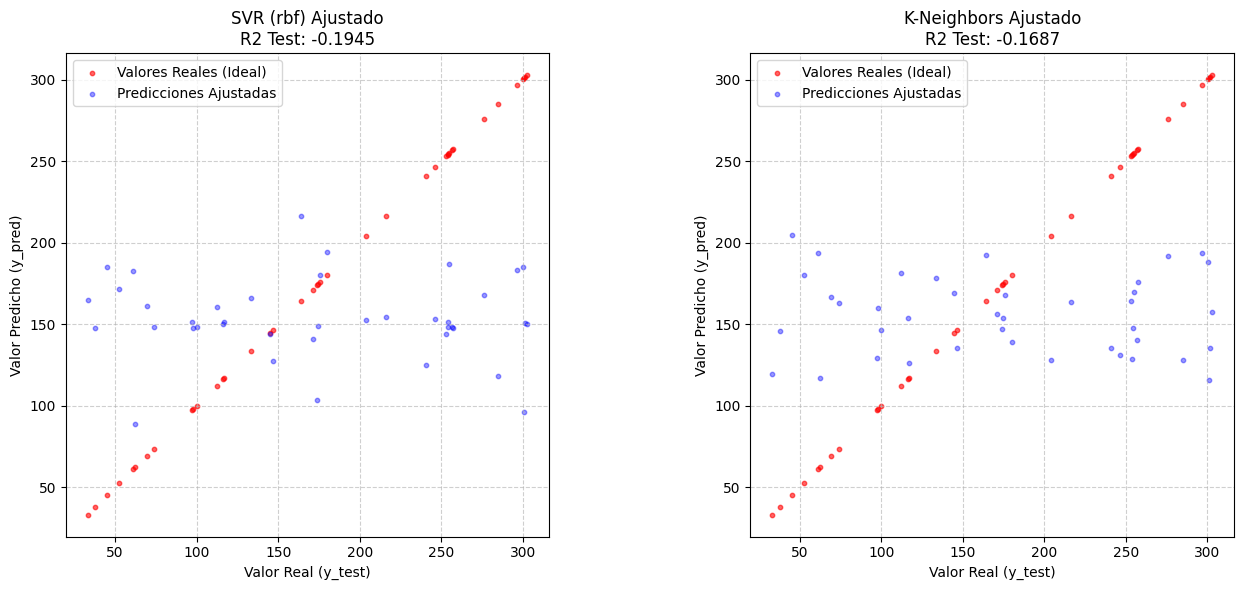

In [83]:
import matplotlib.pyplot as plt

# Obtener las predicciones de los modelos ajustados específicos
best_svr_ajustado_pipeline = regresores_eval['SVR (rbf) - Ajuste 2 (C=100, gamma=0.1)']
best_knn_ajustado_pipeline = regresores_eval['K-Neighbors - Ajuste 3 (n=20, w=distance)']

y_pred_test_svr_ajustado = best_svr_ajustado_pipeline.predict(X_test)
y_pred_test_knn_ajustado = best_knn_ajustado_pipeline.predict(X_test)


# Generación de los gráficos de dispersión
plt.figure(figsize=(14, 6))

# Gráfico para SVR (rbf) ajustado
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test, color='red', label='Valores Reales (Ideal)', alpha=0.6, s=10)
plt.scatter(y_test, y_pred_test_svr_ajustado, color='blue', label='Predicciones Ajustadas', alpha=0.4, s=10)
plt.xlabel('Valor Real (y_test)')
plt.ylabel('Valor Predicho (y_pred)')
plt.title(f"SVR (rbf) Ajustado\nR2 Test: {r2_score(y_test, y_pred_test_svr_ajustado):.4f}")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().set_aspect('equal', adjustable='box')


# Gráfico para K-Neighbors ajustado
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test, color='red', label='Valores Reales (Ideal)', alpha=0.6, s=10)
plt.scatter(y_test, y_pred_test_knn_ajustado, color='blue', label='Predicciones Ajustadas', alpha=0.4, s=10)
plt.xlabel('Valor Real (y_test)')
plt.ylabel('Valor Predicho (y_pred)')
plt.title(f"K-Neighbors Ajustado\nR2 Test: {r2_score(y_test, y_pred_test_knn_ajustado):.4f}")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

e) MSE y R2 mejorado de ambos:

**Para SVR (rbf):**

Modelo ajustado: SVR (rbf) - Ajuste 2 (C=100, gamma=0.1)

MSE_Test mejorado: 2116.7264

R2_Test mejorado: 0.7693

**Para K-Neighbors:**

Modelo ajustado: K-Neighbors - Ajuste 3 (n=20, w=distance)
MSE_Test mejorado: 2394.0786
R2_Test mejorado: 0.7391